# Сафарян Анна, Егорова Алина
## Старославянский

* [**Типология языков**](#typology)
* [**Чтение данных**](#data)
* [**Дескриптивная статистика и задание параметров корпуса**](#ststs)
* [**Кодирование последовательностей и создание генератора**](#encode)
* [**Создание и обучение моделей**](#train)
    * [SimpleRNN](#simple)
    * [LSTM](#lstm)
    * [BiLSTM](#bilstm)
    * [GRU](#gru)
* [Построение графиков и определение переобучения](#graphs)
* [Оценка и сравнение моделей](#choose)
* [**Создание и обучение упрощённых моделей**](#easy-train)
    * [SimpleRNN](#easy-simple)
    * [LSTM](#easy-lstm)
    * [BiLSTM](#easi-bilstm)
    * [GRU](#easy-gru)
* [Построение графиков и определение переобучения для упрощённых моделей](#easy-graphs)
* [Оценка и сравнение упрощённых моделей](#easy-choose)
* [**Эксперименты с размерностью скрытого слоя**](#hid)
* [**Эксперименты с эмбеддингами**](#embed)

In [1]:
import conllu
import numpy as np
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, RepeatVector
from keras.layers.embeddings import Embedding
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from os import makedirs
import matplotlib.pyplot as plt
from json import dump, load
from collections import defaultdict
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

Using TensorFlow backend.


## Типология языков <a id="typology"></a>

| Типология | Старославянский | Финский |
|------------- |---------------|-------------|
| **Генеалогическая: семья**  | Индоевропейская | Уральская | 
| **Генеалогическая: ветвь** | Славянские | Финно-угорские |
| **Морфологическая** | Синтетический (флективный) | Синтетический (агглютинативный) |
| **Морфосинтаксическая** | Номинативный | Номинативный |
| **Порядок слов: ветвление** | SVO, левое | SVO, левое |
| **Порядок слов: свобода** | свободный | относительно свободный |


Во всём, что определяет порядок слов (а значит и тегов), разницы нет. Разве что может быть разница в самих тегах.

## Чтение данных <a id="вфеф"></a>

Нам милостиво предоставили тестовую и тренировочную выборки -- их и возьмём.

In [2]:
train_raw = open('cu\\cu-train.conllu', 'r', encoding='utf-8').read().lower()
train_data = conllu.parse(train_raw)
print(len(train_data))
test_raw = open('cu\\cu-test.conllu', 'r', encoding='utf-8').read().lower()
test_data = conllu.parse(test_raw)
print(len(test_data))

4123
1141


Вряд ли где-то можно найти морфологический анализатор старославянских текстов, так что лемматизацию проводить не будем, хотя в случае омоформ ("пила", например) она могла бы снять неоднозначность.

In [3]:
def get_data(data):
    sents = [] # список списков токенов
    tags = [] # список списков тегов
    word_vocab = set() # множество уникальных токенов
    pos_vocab = set() # множество уникальных 
    pos_freq = defaultdict(int) # частота встречаемости pos-тегов
    for l in data:
        #print(l)
        sent = []
        tag = []
        for tok in l:
            #print(tok)
            sent.append(tok['form'])
            tag.append(tok['upostag'])
            word_vocab.add(tok['form'])
            pos_vocab.add(tok['upostag'])
            pos_freq[tok['upostag']] += 1
        sents.append(sent)
        tags.append(tag)
    return sents, tags, word_vocab, pos_vocab, dict(pos_freq)

In [4]:
train_sents, train_tags, train_word_vocab, train_pos_vocab, train_pos_freq = get_data(train_data)
test_sents, test_tags, test_word_vocab, test_pos_vocab, test_pos_freq = get_data(test_data)

In [5]:
for s, t in zip(train_sents[:3], train_tags[:3]):
    print(s)
    print(t)
    print()
print(train_pos_vocab)
#print(train_word_vocab)

['ꙇ', 'вьлѣзъ', 'въ', 'корабь', 'и҃съ', 'прѣѣде', 'ꙇ', 'приде', 'въ', 'свои', 'градъ']
['cconj', 'verb', 'adp', 'noun', 'propn', 'verb', 'cconj', 'verb', 'adp', 'adj', 'noun']

['ꙇ', 'се', 'принѣсѧ', 'емоу', 'ослабленъ', 'жилами', 'на', 'одрѣ', 'лежѧщъ']
['cconj', 'intj', 'verb', 'pron', 'verb', 'noun', 'adp', 'noun', 'verb']

['ꙇ', 'видѣвъ', 'и҃съ', 'вѣрѫ', 'ихъ', 'рече', 'ослабленоуемоу']
['cconj', 'verb', 'propn', 'noun', 'pron', 'verb', 'verb']

{'intj', 'aux', 'adv', 'adj', 'sconj', 'verb', 'det', 'num', 'propn', 'pron', 'noun', 'cconj', 'x', 'adp'}


In [6]:
# словари соответствий строим по тренировочной выборке
w2i = {'pad':0, 'unk':1} # за 0 закреплены слова pad, за 1 -- unk, т.е. слова тестовой, которых нет в тренировочной
i2w = {0:'pad', 1:'unk'}

for i, w in enumerate(train_word_vocab):
   w2i[w] = i+2 # прибавляем 2, т.к. добавили 2 своих слова
   i2w[i+2] = w
    
t2i = {'pad':0} # теги для незнакомых слов попробуем предсказывать тоже
i2t = {0:'pad'}
for i, t in enumerate(train_pos_vocab):
   t2i[t] = i+1
   i2t[i+1] = t

print(t2i)

{'pad': 0, 'intj': 1, 'aux': 2, 'adv': 3, 'adj': 4, 'sconj': 5, 'verb': 6, 'det': 7, 'num': 8, 'propn': 9, 'pron': 10, 'noun': 11, 'cconj': 12, 'x': 13, 'adp': 14}


In [7]:
# заменяем все незнакомые слова в тестовой выборке на unk
test_sents_clean = test_sents[:]
count_test_words = 0
count_unk = 0
for s, sent in enumerate(test_sents):
    for w, word in enumerate(sent):
        count_test_words+=1
        if word not in train_word_vocab: # если слова нет в словаре тренировочной выборки
            test_sents_clean[s][w] = 'unk' # заменяем слово в "чистой" тестовой выборке
            count_unk+=1
print(count_test_words)
print(count_unk)
print(test_sents_clean[:10])

10031
1380
[['не', 'осѫждаите', 'да', 'не', 'unk', 'бѫдете'], ['ꙇмъже', 'бо', 'unk', 'сѫдите', 'сѫдѧтъ', 'вамъ', 'ꙇ', 'въ', 'нѭже', 'мѣрѫ', 'мѣрите', 'вьзмѣритъ', 'сѧ', 'вамъ'], ['что', 'же', 'видиши', 'сѫчецъ', 'въ', 'оцѣ', 'братра', 'твоего', 'а', 'бръвъна', 'еже', 'естъ', 'въ', 'оцѣ', 'твоемь', 'не', 'чюеши', 'ли', 'како', 'речеши', 'братроу', 'твоемоу'], ['остави', 'и', 'изъмѫ', 'сѫчецъ', 'из', 'очесе', 'твоего'], ['ꙇ', 'се', 'бръвъно', 'въ', 'оцѣ', 'твоемь'], ['лицемѣре', 'unk', 'пръвѣе', 'бръвъно', 'из', 'очесе', 'твоего', 'ꙇ҅', 'тогда', 'оузьриши', 'изѧти', 'сѫчецъ', 'из', 'очесе', 'братра', 'твоего'], ['не', 'дадите', 'unk', 'псомъ', 'ни', 'unk', 'бисьръ', 'вашихъ', 'прѣдъ', 'unk', 'да', 'не', 'unk', 'ихъ', 'unk', 'своими', 'ꙇ҅', 'unk', 'сѧ', 'unk', 'вꙑ'], ['просите', 'и', 'дастъ', 'сѧ', 'вамъ'], ['unk', 'и', 'обрѧщете'], ['unk', 'и', 'отвръзетъ', 'сѧ', 'вамъ']]


## Дескриптивная статистика <a id="stats"></a>
* Число предложений / уникальных словоформ;
* Число уникальных PoS-тегов;
* Максимальное и минимальное число слов в предложении;
* Математическое ожидание и медиана числа слов в предложении;
* Доля новых (не встречавшихся в тренировочной выборке) слов в тестовой выборке
* Гистограммы распределения частей речи в тренировочном и тестовом корпусе

In [8]:
train_lens = [len(i) for i in train_sents]
print(train_lens[:20])
test_lens = [len(i) for i in test_sents_clean]
print(test_lens[:20])
dif = len(test_word_vocab-train_word_vocab)*100/(len(test_word_vocab)+2) # сколько есть "незнакомых" слов в словаре тестовой выборки
pr = count_unk*100/count_test_words # сколько процентов такие слова составляют от тестового корпуса 

print('''
\t\tTrain\tTest
n_sents:\t{}\t{}
n_words:\t{}\t{}
n_tags: \t{}\t{}
max_len:\t{}\t{}
min_len:\t{}\t{}
mean_len:\t{}\t{}
med_len:\t{}\t{}
{}% тестового словаря нет в тренировочном. Это {}% тестового корпуса.
'''.format(
    len(train_lens), len(test_lens),
    len(train_word_vocab)+2, len(test_word_vocab)+2, # нормальные слова + pad, unk 
    len(train_pos_vocab)+1, len(test_pos_vocab)+1, # нормальные теги + pad
    np.max(train_lens), np.max(test_lens), 
    np.min(train_lens), np.min(test_lens), 
    round(np.mean(train_lens), 1), round(np.mean(test_lens), 1), 
    round(np.median(train_lens), 1), round(np.median(test_lens), 1),
    round(dif,2), round(pr,2)))

[11, 9, 7, 1, 5, 8, 2, 6, 7, 11, 2, 12, 3, 9, 12, 15, 3, 5, 20, 6]
[6, 14, 22, 7, 6, 16, 21, 5, 3, 5, 11, 16, 8, 23, 14, 6, 3, 9, 5, 9]

		Train	Test
n_sents:	4123	1141
n_words:	7595	3193
n_tags: 	15	15
max_len:	92	43
min_len:	1	1
mean_len:	9.1	8.8
med_len:	7.0	7.0
37.86% тестового словаря нет в тренировочном. Это 13.76% тестового корпуса.



In [13]:
# Для гистограммы словари абсолютных частот переведём в словари относительных 
train_pos_rel = {pos: freq/np.sum(train_lens) for pos, freq in zip(train_pos_freq.keys(), train_pos_freq.values())}
test_pos_rel = {pos: freq/np.sum(test_lens) for pos, freq in zip(test_pos_freq.keys(), test_pos_freq.values())}

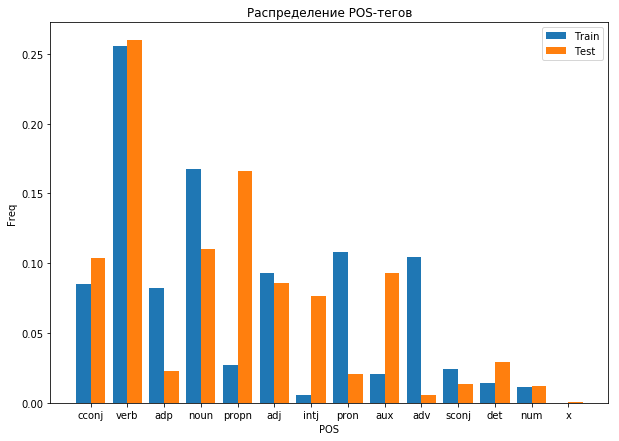

In [14]:
plt.subplots(figsize=(10, 7))

plt.bar(np.arange(14)-0.2, list(train_pos_rel.values()), 0.4, label = 'Train')
plt.bar(np.arange(14)+0.2, list(test_pos_rel.values()), 0.4, label = 'Test')
plt.xlabel('POS')
plt.ylabel('Freq')
plt.title('Распределение POS-тегов')
plt.xticks(np.arange(14), list(train_pos_rel.keys()))
plt.legend()
plt.show()

В тренировочном корпусе больше всего глаголов и существительных, что логично, а вот в тестовом внезапно преобладают, помимо глаголов, имена собственные. Ожидаемо по чуть-чуть всяких странных слов без частей речи (тег "х"), но почему-то мало наречий, в то время как в тренировочном корпусе количество наречий соспоставимо с количеством местоимений и прилагательных. Почему-то в тестовом корпусе больше междометий, вспомогательных глаголов и детерминативов. А ещё в тренировочном корпусе больше сочинительных союзов, а в тестовом -- подчинительных.

Учитывая то, что медианная длина предложения в тренировочном корпусе = 7, мы могли бы взять гораздо меньшуу длину последовательности. Однако сокращение максимальной длины до 30 внезапно привело к ухудшению предсказаний без паддингов (bleu упала). Возможно, там обрезались какие-то слова и последовательности, которые не встретились (или мало встречались) в уцелевших последовательностях, поэтому мы стали распознавать их хуже.

In [48]:
max_len = np.max(train_lens) 
n_words = len(train_word_vocab)+2
n_tags = len(train_pos_vocab)+1
batch_size = 64

## Кодирование последовательностей и создание генератора <a id="encode"></a>

In [49]:
# кодируем последовательности и дополняем их нулями до максимальной длины
def encode_sequences(sequences, dict2index, maxlen=max_len):
    enc_seqs = [[dict2index[word] for word in seq[:maxlen]] for seq in sequences] # предложение урезаем до максимальной длины в тренировочной выборке
    enc_seqs = pad_sequences(enc_seqs, maxlen, padding='post')
    return enc_seqs

In [50]:
# унитарно кодируем метки (принимаем уже закодированные на предыдущем шаге последователности)
def onehot_sequences(sequences):
    enc_seqs = []
    for sequence in sequences: 
        encoded = to_categorical(sequence, num_classes=n_tags) 
        enc_seqs.append(encoded)
    enc_seqs = np.array(enc_seqs)
    return enc_seqs

In [51]:
# проверим, как работает
# возьмём последовательность не 92, а 10, чтобы нормально отобразились матрицы, а то они иначе сжимаются посередине
es = encode_sequences(test_sents_clean[:2], dict2index=w2i, maxlen=10) 
et = encode_sequences(test_tags[:2], dict2index=t2i, maxlen=10)
print(es.shape)
et = onehot_sequences(et) 
print(et.shape)
for i in range(2):
    print(test_sents[i]),
    print(es[i], len(es[i])),
    print(test_tags[i]),
    print(et[i], len(et[i])),
    print()
# видно, что короткие дополняются, длинные обрезаются

(2, 10)
(2, 10, 15)
['не', 'осѫждаите', 'да', 'не', 'unk', 'бѫдете']
[3049  445  202 3049    1 1456    0    0    0    0] 10
['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 10

['ꙇмъже', 'бо', 'unk', 'сѫдите', 'сѫдѧтъ', 'вамъ', 'ꙇ', 'въ', 'нѭже', 'мѣрѫ', 'мѣрите', 'вьзмѣритъ', 'сѧ', 'вамъ']
[5995 6717    1 6904 5241 2626 4142 1980 2766 6755] 10
['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 

In [52]:
# чтобы избавиться от MemoryError, воспользуемся генератором батчей
def gen_batch(sents, tags, batch_size):
    i = 0
    all_sents  = len(sents) # всего последовательностей
    n_sents = batch_size * int(all_sents / batch_size)  #сколько у нас влезет (батч * кол-во батчей)
    #print(n_sents)
    while True:
        #print(i)
        i = i % n_sents # считаем текущий индекс (где новое)
        # берём кусочки
        sub_sents = sents[i: i+batch_size]
        sub_tags = tags[i: i+batch_size]

        # кодируем кусочки
        sub_sents = encode_sequences(sub_sents, dict2index=w2i, maxlen=max_len)
        sub_tags = encode_sequences(sub_tags, dict2index=t2i, maxlen=max_len)
        sub_tags = onehot_sequences(sub_tags)
        
        # обновляем текущий индекс
        i += batch_size
        #print(i)
        
        yield sub_sents, sub_tags # возвращаем наши кусочки

Так как проводить валидацию на тестовой выборке всё-таки не очень хорошо, тренировочную выборку поделим на собственно тренировочную и валидационную. 


In [53]:
train_sents, val_sents, train_tags, val_tags = train_test_split(train_sents, train_tags, test_size=0.2, shuffle=True)
print(len(train_sents))
print(len(val_sents))

3298
825


In [54]:
epochs = 20
steps = int(len(train_sents)/batch_size) # считаем шаги для генератора
print(steps)
val_steps = int(len(val_sents)/batch_size)
print(val_steps)
test_steps = int(len(test_sents)/batch_size)
print(test_steps)
n_hidden = 128 # возьмём средненькое, чтобы можно было вверх и вниз менять
embed_size = 100

51
12
17


In [55]:
for model_type in ['simple', 'lstm', 'bilstm', 'gru']: # создадим папки для хранения чекпойнтов моделей
    try:
        makedirs('cu\\{}'.format(model_type))
    except OSError:
        pass

## Создание и обучение моделей <a id="train"></a>

Поначалу мы взяли более сложные архитектуры, но оказалось, что они очень плохо работают для такой простой задачи -- им подавай два языка на перевод, а не вот это вот всё) После всё то же самое будет проведено для архитектурок попроще

### SimpleRNN <a id="simple"></a>

In [81]:
simple_model = Sequential()
simple_model.add(Embedding(n_words, embed_size, input_length=max_len))
simple_model.add(SimpleRNN(n_hidden, unroll=True))
simple_model.add(RepeatVector(max_len))
simple_model.add(SimpleRNN(n_hidden, return_sequences=True, unroll=True))
simple_model.add(TimeDistributed(Dense(n_tags)))
simple_model.add(Activation("softmax"))

simple_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 92, 100)           759500    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 128)               29312     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 92, 128)           0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 92, 128)           32896     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 92, 15)            1935      
_________________________________________________________________
activation_4 (Activation)    (None, 92, 15)            0         
Total params: 823,643
Trainable params: 823,643
Non-trainable params: 0
_________________________________________________________________


In [83]:
checkpoint = ModelCheckpoint('cu\\simple\\cu-simple_model-{epoch:02d}.h5', verbose=1, save_best_only=False)
simple_history = simple_model.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(simple_history.history, open('cu\\simple\\cu-simple_model-history.json','w', encoding='utf-8'))

Epoch 1/20
51/51 [==============================] - 13s 259ms/step - loss: 0.4865 - acc: 0.9049 - val_loss: 0.4910 - val_acc: 0.8998

Epoch 00001: saving model to cu\simple\cu-simple_model-01.h5
Epoch 2/20
51/51 [==============================] - 12s 242ms/step - loss: 0.4533 - acc: 0.9055 - val_loss: 0.4457 - val_acc: 0.9034

Epoch 00002: saving model to cu\simple\cu-simple_model-02.h5
Epoch 3/20
51/51 [==============================] - 15s 299ms/step - loss: 0.3738 - acc: 0.9105 - val_loss: 0.3878 - val_acc: 0.9064

Epoch 00003: saving model to cu\simple\cu-simple_model-03.h5
Epoch 4/20
51/51 [==============================] - 15s 288ms/step - loss: 0.3388 - acc: 0.9112 - val_loss: 0.3513 - val_acc: 0.9063

Epoch 00004: saving model to cu\simple\cu-simple_model-04.h5
Epoch 5/20
51/51 [==============================] - 13s 262ms/step - loss: 0.3295 - acc: 0.9111 - val_loss: 0.3706 - val_acc: 0.9066

Epoch 00005: saving model to cu\simple\cu-simple_model-05.h5
Epoch 6/20
51/51 [=======

### LSTM <a id="lstm"></a>

In [27]:
lstm_model = Sequential()
lstm_model.add(Embedding(n_words, embed_size, input_length=max_len))
lstm_model.add(LSTM(n_hidden, unroll=True))
lstm_model.add(RepeatVector(max_len))
lstm_model.add(LSTM(n_hidden, return_sequences=True, unroll=True))
lstm_model.add(TimeDistributed(Dense(n_tags)))
lstm_model.add(Activation("softmax"))

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 100)           759500    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 15)            1935      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 15)            0         
Total params: 1,010,267
Trainable params: 1,010,267
Non-trainable params: 0
_________________________________________________________________


In [29]:
checkpoint = ModelCheckpoint('cu\\lstm\\cu-lstm_model-{epoch:02d}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_history = lstm_model.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(lstm_history.history, open('cu\\lstm\\cu-lstm_model-history.json','w', encoding='utf-8'))

Epoch 1/10
51/51 [==============================] - 26s 518ms/step - loss: 1.2735 - acc: 0.6910 - val_loss: 0.9705 - val_acc: 0.7072

Epoch 00001: saving model to cu\lstm\cu-lstm_model-01.h5
Epoch 2/10
51/51 [==============================] - 9s 186ms/step - loss: 0.8049 - acc: 0.7448 - val_loss: 0.7633 - val_acc: 0.7483

Epoch 00002: saving model to cu\lstm\cu-lstm_model-02.h5
Epoch 3/10
51/51 [==============================] - 10s 188ms/step - loss: 0.7086 - acc: 0.7660 - val_loss: 0.7455 - val_acc: 0.7507

Epoch 00003: saving model to cu\lstm\cu-lstm_model-03.h5
Epoch 4/10
51/51 [==============================] - 9s 184ms/step - loss: 0.6987 - acc: 0.7662 - val_loss: 0.7291 - val_acc: 0.7559

Epoch 00004: saving model to cu\lstm\cu-lstm_model-04.h5
Epoch 5/10
51/51 [==============================] - 9s 182ms/step - loss: 0.6685 - acc: 0.7711 - val_loss: 0.6964 - val_acc: 0.7604

Epoch 00005: saving model to cu\lstm\cu-lstm_model-05.h5
Epoch 6/10
51/51 [==============================

### BiLSTM <a id="bilstm"></a>

In [86]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(n_words, embed_size, input_length=max_len))
bilstm_model.add(Bidirectional(LSTM(n_hidden, unroll=True)))
bilstm_model.add(RepeatVector(max_len))
bilstm_model.add(Bidirectional(LSTM(n_hidden, return_sequences=True, unroll=True)))
bilstm_model.add(TimeDistributed(Dense(n_tags)))
bilstm_model.add(Activation("softmax"))

bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
bilstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 92, 100)           759500    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 92, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 92, 256)           394240    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 92, 15)            3855      
_________________________________________________________________
activation_6 (Activation)    (None, 92, 15)            0         
Total params: 1,392,091
Trainable params: 1,392,091
Non-trainable params: 0
_________________________________________________________________


In [87]:
checkpoint = ModelCheckpoint('cu\\bilstm\\cu-bilstm_model-{epoch:02d}.h5', verbose=1, save_best_only=False)
bilstm_history = bilstm_model.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint], workers=-1)
dump(bilstm_history.history, open('cu\\bilstm\\cu-bilstm_model-history.json','w', encoding='utf-8'))

Epoch 1/20
51/51 [==============================] - 652s 13s/step - loss: 0.6595 - acc: 0.8850 - val_loss: 0.3010 - val_acc: 0.9056

Epoch 00001: saving model to cu\bilstm\cu-bilstm_model-01.h5
Epoch 2/20
51/51 [==============================] - 596s 12s/step - loss: 0.2798 - acc: 0.9144 - val_loss: 0.2661 - val_acc: 0.9157

Epoch 00002: saving model to cu\bilstm\cu-bilstm_model-02.h5
Epoch 3/20
51/51 [==============================] - 609s 12s/step - loss: 0.2542 - acc: 0.9197 - val_loss: 0.2655 - val_acc: 0.9168

Epoch 00003: saving model to cu\bilstm\cu-bilstm_model-03.h5
Epoch 4/20
51/51 [==============================] - 803s 16s/step - loss: 0.2567 - acc: 0.9193 - val_loss: 0.2621 - val_acc: 0.9162

Epoch 00004: saving model to cu\bilstm\cu-bilstm_model-04.h5
Epoch 5/20
51/51 [==============================] - 665s 13s/step - loss: 0.2496 - acc: 0.9205 - val_loss: 0.2526 - val_acc: 0.9179

Epoch 00005: saving model to cu\bilstm\cu-bilstm_model-05.h5
Epoch 6/20
51/51 [============

### GRU <a id="gru"></a>

In [90]:
gru_model = Sequential()
gru_model.add(Embedding(n_words, embed_size, input_length=max_len))
gru_model.add(GRU(n_hidden, unroll=True))
gru_model.add(RepeatVector(max_len))
gru_model.add(GRU(n_hidden, return_sequences=True, unroll=True))
gru_model.add(TimeDistributed(Dense(n_tags)))
gru_model.add(Activation("softmax"))

gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 92, 100)           759500    
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               87936     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 92, 128)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 92, 128)           98688     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 92, 15)            1935      
_________________________________________________________________
activation_8 (Activation)    (None, 92, 15)            0         
Total params: 948,059
Trainable params: 948,059
Non-trainable params: 0
_________________________________________________________________


In [91]:
checkpoint = ModelCheckpoint('cu\\gru\\cu-gru_model-{epoch:02d}.h5', verbose=1, save_best_only=False)
gru_history = gru_model.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint], workers=-1)
dump(gru_history.history, open('cu\\gru\\cu-gru_model-history.json','w', encoding='utf-8'))

Epoch 1/20
51/51 [==============================] - 440s 9s/step - loss: 0.7956 - acc: 0.8843 - val_loss: 0.4000 - val_acc: 0.8971

Epoch 00001: saving model to cu\gru\cu-gru_model-01.h5
Epoch 2/20
51/51 [==============================] - 364s 7s/step - loss: 0.3552 - acc: 0.9031 - val_loss: 0.3585 - val_acc: 0.9054

Epoch 00002: saving model to cu\gru\cu-gru_model-02.h5
Epoch 3/20
51/51 [==============================] - 337s 7s/step - loss: 0.3379 - acc: 0.9107 - val_loss: 0.3526 - val_acc: 0.9063

Epoch 00003: saving model to cu\gru\cu-gru_model-03.h5
Epoch 4/20
51/51 [==============================] - 370s 7s/step - loss: 0.3339 - acc: 0.9110 - val_loss: 0.3503 - val_acc: 0.9063

Epoch 00004: saving model to cu\gru\cu-gru_model-04.h5
Epoch 5/20
51/51 [==============================] - 347s 7s/step - loss: 0.3318 - acc: 0.9109 - val_loss: 0.3489 - val_acc: 0.9063

Epoch 00005: saving model to cu\gru\cu-gru_model-05.h5
Epoch 6/20
51/51 [==============================] - 332s 7s/step 

В теории GRU вроде как должен быть шустрее LSTM, потому что производит меньше вычислений, но у LSTM 1 секунда на шаг, а тут 7... Ладно, спишем это на постороннюю загрузку компа.

## Построение графиков и определение переобучения <a id="graphs"></a>

In [36]:
# функции для визуализации красоты

def vis_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(history_dict['acc']) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss') # пришлось делать точечками, а не линиями, потому что иначе не чётко видно эпохи на графике
    plt.plot(epochs, val_loss_values, 'ro', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def vis_acc(history):
    history_dict = history.history
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']

    epochs = range(1, len(history_dict['acc']) + 1)

    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'ro', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

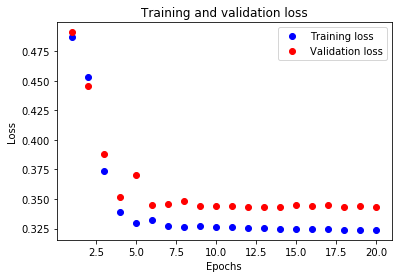

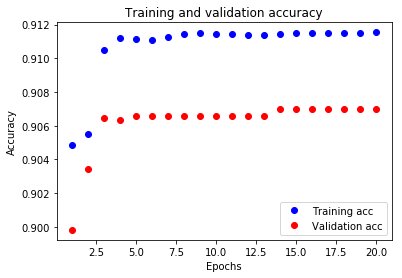

In [95]:
vis_loss(simple_history)
vis_acc(simple_history)

In [20]:
n_simple = 14  #лучшее количество эпох для модели, дальше точность на валидационном корпусе стабилизировалось (а время на обучение зря потратили :с)

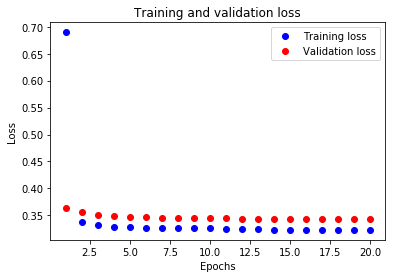

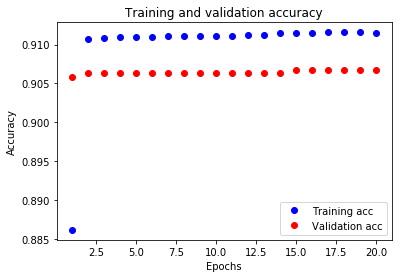

In [97]:
vis_loss(lstm_history)
vis_acc(lstm_history)

In [21]:
n_lstm = 15 # дальше тоже стабилизировалась

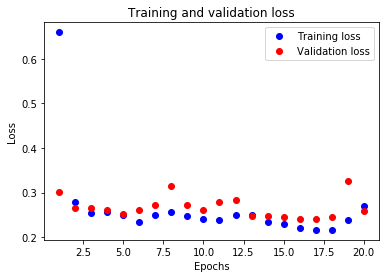

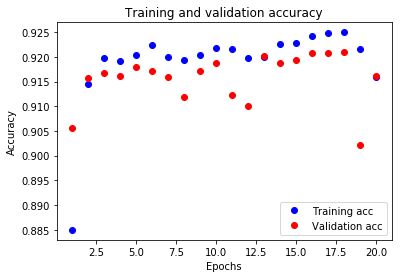

In [99]:
vis_loss(bilstm_history)
vis_acc(bilstm_history)

In [22]:
n_bilstm = 18 # Это какое-то не совсем переобучение, потому что я не очень понимаю, почему тренировочная точность тоже поползла вниз, но оно тут всё колеблется, так что был шанс, что дальше точность вернётся вверх

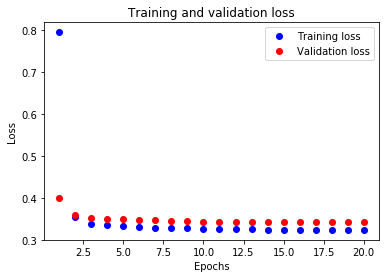

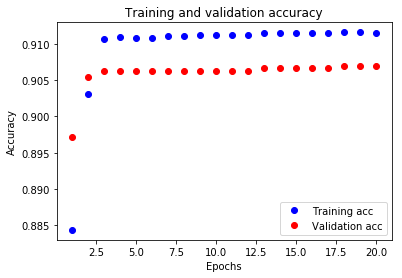

In [101]:
vis_loss(gru_history)
vis_acc(gru_history)

In [23]:
n_gru = 18 # дальше стабилизировалась

Переобучиться мы так нигде и не переобучились, но после определённого числа эпох некоторые модели показывали стабильно один и тот же результат.

## Оценка и сравнение моделей <a id="choose"></a>

Подгружаем лучшие модели и оцениваем на тестовой выборке

In [26]:
best_simple = load_model('cu\\simple\\cu-simple_model-{}.h5'.format(n_simple))
simple_evals = best_simple.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [27]:
best_lstm = load_model('cu\\lstm\\cu-lstm_model-{}.h5'.format(n_lstm))
lstm_evals = best_lstm.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [28]:
best_bilstm = load_model('cu\\bilstm\\cu-bilstm_model-{}.h5'.format(n_bilstm))
bilstm_evals = best_bilstm.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [29]:
best_gru = load_model('cu\\gru\\cu-gru_model-{}.h5'.format(n_gru))
gru_evals = best_gru.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [30]:
print('''
\tLoss\tAcc
Simple:\t{}\t{}
LSTM:\t{}\t{}
BiLSTM:\t{}\t{}
GRU:\t{}\t{}'''.format(
    round(simple_evals[0], 5), round(simple_evals[1], 5),
    round(lstm_evals[0], 5), round(lstm_evals[1], 5),
    round(bilstm_evals[0], 5), round(bilstm_evals[1], 5), 
    round(gru_evals[0], 5), round(gru_evals[1], 5)))


	Loss	Acc
Simple:	0.42369	0.90663
LSTM:	0.42352	0.90411
BiLSTM:	0.35282	0.90947
GRU:	0.42277	0.90663


Модели показывают примерно одинаковые результаты, но это довольно формальная оценка, потому что паддинги, которые составляют большую часть всех текстов, предсказывать просто. Попробуем раскодировать последовательности тегов обратно и посчитать BLEU -- она как раз для того и нужна.

In [35]:
def decode_sequences(preds): 
    dec_tags = []
    dec_seqs = []
    for i, pred in enumerate(preds):
        #print(i, pred.shape)
        dec_seq = []
        for vector in pred:
            #print(vector.shape, vector)
            max_idx = np.argmax(vector)
            #print(max_idx, np.max(vector))
            #print()
            dec_seq.append(max_idx)
            #print(i, dec_seq)
        dec_seqs.append(dec_seq)
        
        decoded = [i2t[idx] for idx in dec_seq if idx != 0] # обрубаем маддинги
        #print(decoded)
        dec_tags.append(decoded)
        #print('+'*50)
    return dec_seqs, dec_tags

In [122]:
lstm_preds = best_lstm.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
lstm_dec_seqs, lstm_dec_tags = decode_sequences(lstm_preds)
for i in range(3):
    print(test_tags[i])
    #print(lstm_dec_seqs[i])
    print(lstm_dec_tags[i])
    print()

['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
['adp', 'noun', 'adp', 'adp']

['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
['adp', 'noun', 'adp', 'adp']

['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'cconj', 'adv', 'verb', 'noun', 'adj']
['adp', 'noun', 'adp', 'adp']



In [123]:
bilstm_preds = best_bilstm.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
bilstm_dec_seqs, bilstm_dec_tags = decode_sequences(bilstm_preds)
for i in range(3):
    print(test_tags[i])
    #print(bilstm_dec_seqs[i])
    print(bilstm_dec_tags[i])
    print()

['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
['adp', 'adp', 'adp', 'adp', 'adp', 'adp']

['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
['adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp']

['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'cconj', 'adv', 'verb', 'noun', 'adj']
['adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp']



In [124]:
gru_preds = best_gru.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
gru_dec_seqs, gru_dec_tags = decode_sequences(bilstm_preds)
for i in range(3):
    print(test_tags[i])
    #print(gru_dec_seqs[i])
    print(gru_dec_tags[i])
    print()

['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
['adp', 'adp', 'adp', 'adp', 'adp', 'adp']

['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
['adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp']

['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'cconj', 'adv', 'verb', 'noun', 'adj']
['adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp', 'adp']



Но всё оказалось настолько плохо, что даже считать что-то стало бессмысленным :с

## Упрощение модели <a id="easy"></a>

Как уже было сказано, мы решили перейти от сложных архитектур с мудрёными слоями к простым.

In [64]:
# показатели довольно быстро более-менее стабилизируются, а обучаются всё-таки долго, заразы, поэтому 
epochs = 10

In [57]:
for model_type in ['simple', 'lstm', 'bilstm', 'gru']:
    try:
        makedirs('cu\\easy-{}'.format(model_type))
    except OSError:
        pass

### SimpleRNN

In [58]:
easy_simple = Sequential()
easy_simple.add(Embedding(n_words, embed_size, input_length=max_len))
easy_simple.add(SimpleRNN(n_hidden, return_sequences=True, unroll=True))
easy_simple.add(Dense(n_tags, activation="softmax"))

easy_simple.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
easy_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 92, 100)           759500    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 92, 128)           29312     
_________________________________________________________________
dense_4 (Dense)              (None, 92, 15)            1935      
Total params: 790,747
Trainable params: 790,747
Non-trainable params: 0
_________________________________________________________________


In [59]:
checkpoint = ModelCheckpoint('cu\\easy-simple\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
easy_simple_history = easy_simple.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(easy_simple_history.history, open('cu\\easy-simple\\cu-easy_model-history.json','w', encoding='utf-8'))

Epoch 1/10
51/51 [==============================] - 13s 252ms/step - loss: 0.5590 - acc: 0.8899 - val_loss: 0.3590 - val_acc: 0.9074

Epoch 00001: saving model to cu\easy-simple\cu-easy_model-1.h5
Epoch 2/10
51/51 [==============================] - 8s 156ms/step - loss: 0.2860 - acc: 0.9201 - val_loss: 0.2726 - val_acc: 0.9221

Epoch 00002: saving model to cu\easy-simple\cu-easy_model-2.h5
Epoch 3/10
51/51 [==============================] - 8s 161ms/step - loss: 0.2390 - acc: 0.9351 - val_loss: 0.2518 - val_acc: 0.9288

Epoch 00003: saving model to cu\easy-simple\cu-easy_model-3.h5
Epoch 4/10
51/51 [==============================] - 8s 157ms/step - loss: 0.2104 - acc: 0.9445 - val_loss: 0.2197 - val_acc: 0.9425

Epoch 00004: saving model to cu\easy-simple\cu-easy_model-4.h5
Epoch 5/10
51/51 [==============================] - 8s 154ms/step - loss: 0.1753 - acc: 0.9590 - val_loss: 0.1828 - val_acc: 0.9571

Epoch 00005: saving model to cu\easy-simple\cu-easy_model-5.h5
Epoch 6/10
51/51 [=

### LSTM

In [65]:
easy_lstm = Sequential()
easy_lstm.add(Embedding(n_words, embed_size, input_length=max_len))
easy_lstm.add(LSTM(n_hidden, return_sequences=True, unroll=True))
easy_lstm.add(Dense(n_tags, activation="softmax"))

easy_lstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
easy_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 92, 100)           759500    
_________________________________________________________________
lstm_3 (LSTM)                (None, 92, 128)           117248    
_________________________________________________________________
dense_5 (Dense)              (None, 92, 15)            1935      
Total params: 878,683
Trainable params: 878,683
Non-trainable params: 0
_________________________________________________________________


In [66]:
checkpoint = ModelCheckpoint('cu\\easy-lstm\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
easy_lstm_history = easy_lstm.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(easy_lstm_history.history, open('cu\\easy-lstm\\cu-easy_model-history.json','w', encoding='utf-8'))

Epoch 1/10
51/51 [==============================] - 70s 1s/step - loss: 0.7704 - acc: 0.8843 - val_loss: 0.3485 - val_acc: 0.8987

Epoch 00001: saving model to cu\easy-lstm\cu-easy_model-1.h5
Epoch 2/10
51/51 [==============================] - 27s 521ms/step - loss: 0.3054 - acc: 0.9047 - val_loss: 0.3242 - val_acc: 0.9004

Epoch 00002: saving model to cu\easy-lstm\cu-easy_model-2.h5
Epoch 3/10
51/51 [==============================] - 28s 555ms/step - loss: 0.2781 - acc: 0.9057 - val_loss: 0.2874 - val_acc: 0.9008

Epoch 00003: saving model to cu\easy-lstm\cu-easy_model-3.h5
Epoch 4/10
51/51 [==============================] - 31s 615ms/step - loss: 0.2588 - acc: 0.9084 - val_loss: 0.2810 - val_acc: 0.9084

Epoch 00004: saving model to cu\easy-lstm\cu-easy_model-4.h5
Epoch 5/10
51/51 [==============================] - 26s 506ms/step - loss: 0.2429 - acc: 0.9162 - val_loss: 0.2845 - val_acc: 0.9159

Epoch 00005: saving model to cu\easy-lstm\cu-easy_model-5.h5
Epoch 6/10
51/51 [==========

### BiLSTM

In [67]:
easy_bilstm = Sequential()
easy_bilstm.add(Embedding(n_words, embed_size, input_length=max_len))
easy_bilstm.add(Bidirectional(LSTM(n_hidden, return_sequences=True, unroll=True)))
easy_bilstm.add(Dense(n_tags, activation="softmax"))

easy_bilstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
easy_bilstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 92, 100)           759500    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 92, 256)           234496    
_________________________________________________________________
dense_6 (Dense)              (None, 92, 15)            3855      
Total params: 997,851
Trainable params: 997,851
Non-trainable params: 0
_________________________________________________________________


In [68]:
checkpoint = ModelCheckpoint('cu\\easy-bilstm\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
easy_bilstm_history = easy_bilstm.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(easy_bilstm_history.history, open('cu\\easy-bilstm\\cu-easy_model-history.json','w', encoding='utf-8'))

Epoch 1/10
51/51 [==============================] - 238s 5s/step - loss: 0.6639 - acc: 0.8859 - val_loss: 0.2944 - val_acc: 0.9029

Epoch 00001: saving model to cu\easy-bilstm\cu-easy_model-1.h5
Epoch 2/10
51/51 [==============================] - 150s 3s/step - loss: 0.2582 - acc: 0.9172 - val_loss: 0.2588 - val_acc: 0.9204

Epoch 00002: saving model to cu\easy-bilstm\cu-easy_model-2.h5
Epoch 3/10
51/51 [==============================] - 150s 3s/step - loss: 0.2313 - acc: 0.9241 - val_loss: 0.2333 - val_acc: 0.9217

Epoch 00003: saving model to cu\easy-bilstm\cu-easy_model-3.h5
Epoch 4/10
51/51 [==============================] - 156s 3s/step - loss: 0.2173 - acc: 0.9257 - val_loss: 0.2276 - val_acc: 0.9224

Epoch 00004: saving model to cu\easy-bilstm\cu-easy_model-4.h5
Epoch 5/10
51/51 [==============================] - 153s 3s/step - loss: 0.2044 - acc: 0.9283 - val_loss: 0.2086 - val_acc: 0.9330

Epoch 00005: saving model to cu\easy-bilstm\cu-easy_model-5.h5
Epoch 6/10
51/51 [=======

### GRU

In [70]:
easy_gru = Sequential()
easy_gru.add(Embedding(n_words, embed_size, input_length=max_len))
easy_gru.add(GRU(n_hidden, return_sequences=True, unroll=True))
easy_gru.add(Dense(n_tags, activation="softmax"))

easy_gru.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
easy_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 92, 100)           759500    
_________________________________________________________________
gru_2 (GRU)                  (None, 92, 128)           87936     
_________________________________________________________________
dense_8 (Dense)              (None, 92, 15)            1935      
Total params: 849,371
Trainable params: 849,371
Non-trainable params: 0
_________________________________________________________________


In [71]:
checkpoint = ModelCheckpoint('cu\\easy-gru\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
easy_gru_history = easy_gru.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(easy_gru_history.history, open('cu\\easy-gru\\cu-easy_model-history.json','w', encoding='utf-8'))

Epoch 1/10
51/51 [==============================] - 127s 2s/step - loss: 0.8253 - acc: 0.8714 - val_loss: 0.3062 - val_acc: 0.9143

Epoch 00001: saving model to cu\easy-gru\cu-easy_model-1.h5
Epoch 2/10
51/51 [==============================] - 86s 2s/step - loss: 0.2786 - acc: 0.9154 - val_loss: 0.2895 - val_acc: 0.9075

Epoch 00002: saving model to cu\easy-gru\cu-easy_model-2.h5
Epoch 3/10
51/51 [==============================] - 85s 2s/step - loss: 0.2652 - acc: 0.9176 - val_loss: 0.2779 - val_acc: 0.9061

Epoch 00003: saving model to cu\easy-gru\cu-easy_model-3.h5
Epoch 4/10
51/51 [==============================] - 86s 2s/step - loss: 0.2501 - acc: 0.9187 - val_loss: 0.2596 - val_acc: 0.9150

Epoch 00004: saving model to cu\easy-gru\cu-easy_model-4.h5
Epoch 5/10
51/51 [==============================] - 87s 2s/step - loss: 0.2214 - acc: 0.9302 - val_loss: 0.2199 - val_acc: 0.9354

Epoch 00005: saving model to cu\easy-gru\cu-easy_model-5.h5
Epoch 6/10
51/51 [==========================

## Графики

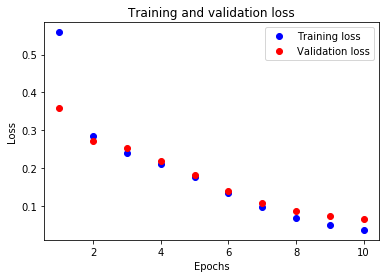

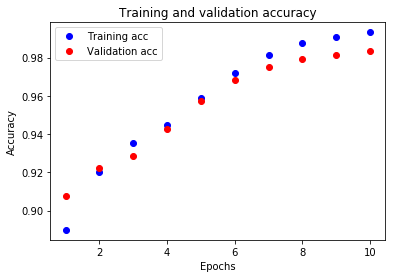

In [72]:
vis_loss(easy_simple_history)
vis_acc(easy_simple_history)

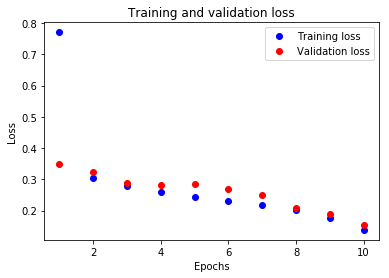

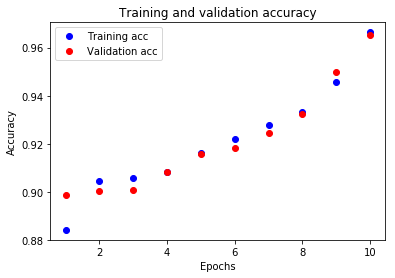

In [73]:
vis_loss(easy_lstm_history)
vis_acc(easy_lstm_history)

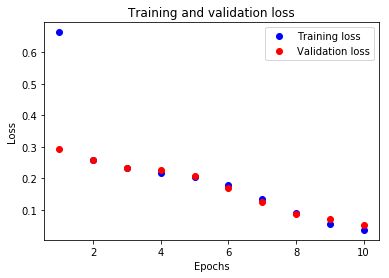

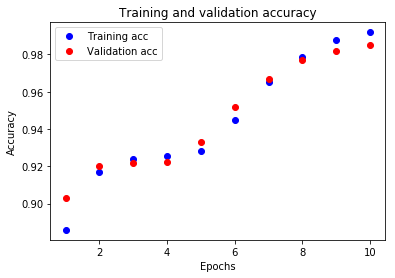

In [74]:
vis_loss(easy_bilstm_history)
vis_acc(easy_bilstm_history)

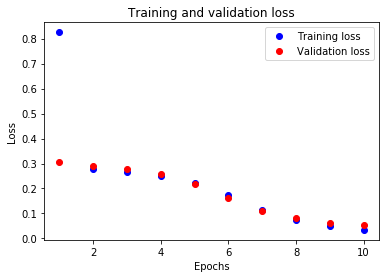

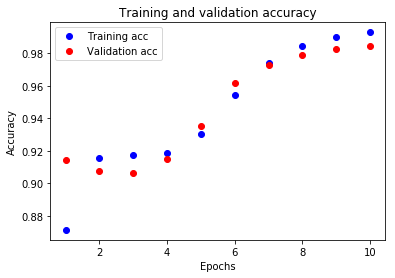

In [75]:
vis_loss(easy_gru_history)
vis_acc(easy_gru_history)

Переобучения нигде не было, как и стабилизации точности, поэтому мы будем использовать последние полученные модели, не подгружая "лучшие"

## Оценка

In [76]:
easy_simple_evals = easy_simple.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [77]:
easy_lstm_evals = easy_lstm.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [78]:
easy_bilstm_evals = easy_bilstm.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [79]:
easy_gru_evals = easy_gru.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [80]:
print('''
\tLoss\tAcc
Simple:\t{}\t{}
LSTM:\t{}\t{}
BiLSTM:\t{}\t{}
GRU:\t{}\t{}'''.format(
    round(easy_simple_evals[0], 5), round(easy_simple_evals[1], 5),
    round(easy_lstm_evals[0], 5), round(easy_lstm_evals[1], 5),
    round(easy_bilstm_evals[0], 5), round(easy_bilstm_evals[1], 5), 
    round(easy_gru_evals[0], 5), round(easy_gru_evals[1], 5)))


	Loss	Acc
Simple:	0.06297	0.98336
LSTM:	0.13294	0.96778
BiLSTM:	0.05132	0.98555
GRU:	0.05012	0.98714


У трёх моделей снова примерно одинаковые результаты, хотя и намного лучше, чем прошлые. А вот LSTM показала себя чуть хуже, чем другие архитектуры, уступив даже простому рекуррентному слою.

In [96]:
easy_simple_pred = easy_simple.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
print(easy_simple_pred.shape)
easy_simple_seqs, easy_simple_tags = decode_sequences(easy_simple_pred)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(easy_simple_tags[i])
    print()

(1088, 92, 15)
['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']

['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
['pron', 'adv', 'verb', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'noun', 'noun', 'aux', 'pron']

['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'cconj', 'adv', 'verb', 'noun', 'adj']
['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'adv', 'verb']



In [98]:
easy_lstm_pred = easy_lstm.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
print(easy_lstm_pred.shape)
easy_lstm_seqs, easy_lstm_tags = decode_sequences(easy_lstm_pred)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(easy_lstm_tags[i])
    print()

(1088, 92, 15)
['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
['adv', 'verb', 'adv', 'adv', 'verb', 'verb']

['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
['verb', 'adv', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron']

['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'cconj', 'adv', 'verb', 'noun', 'adj']
['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'pron', 'verb', 'verb', 'noun', 'noun']



In [99]:
easy_bilstm_pred = easy_bilstm.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
print(easy_bilstm_pred.shape)
easy_bilstm_seqs, easy_bilstm_tags = decode_sequences(easy_bilstm_pred)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(easy_bilstm_tags[i])
    print()

(1088, 92, 15)
['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
['adv', 'verb', 'adv', 'adv', 'verb', 'verb']

['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
['adj', 'adv', 'verb', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'adj', 'verb', 'aux', 'pron']

['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'cconj', 'adv', 'verb', 'noun', 'adj']
['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'adv', 'adv', 'verb', 'noun', 'adj']



In [102]:
easy_gru_pred = easy_gru.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
print(easy_gru_pred.shape)
easy_gru_seqs, easy_gru_tags = decode_sequences(easy_gru_pred)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(easy_gru_tags[i])
    print()

(1088, 92, 15)
['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']

['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
['adv', 'adv', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'noun', 'noun', 'aux', 'pron']

['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'cconj', 'adv', 'verb', 'noun', 'adj']
['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'adv', 'adv', 'verb', 'noun', 'adj']



Не все предсказания верны, но в целом выглядит неплохо.

In [191]:
def bleu_eval(target, predicted):
    bleu_1, bleu_2, bleu_3, bleu_4 = 0, 0, 0, 0 
    sm = SmoothingFunction()
    for t, p in zip(target, predicted):
        bleu_1 += sentence_bleu([t], p, weights=(1.0, 0, 0, 0), smoothing_function=sm.method1) # поюсуем эпсилон
        bleu_2 += sentence_bleu([t], p, weights=(0.5, 0.5, 0, 0), smoothing_function=sm.method1)
        bleu_3 += sentence_bleu([t], p, weights=(0.3, 0.3, 0.3, 0), smoothing_function=sm.method1)
        bleu_4 += sentence_bleu([t], p, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=sm.method1)
    bleu_1 = bleu_1/len(target)
    bleu_2 = bleu_2/len(target)
    bleu_3 = bleu_3/len(target)
    bleu_4 = bleu_4/len(target)
    return bleu_1, bleu_2, bleu_3, bleu_4

In [192]:
simple_bleu_1, simple_bleu_2, simple_bleu_3, simple_bleu_4 = bleu_eval(test_tags[:1088], easy_simple_tags)

In [193]:
lstm_bleu_1, lstm_bleu_2, lstm_bleu_3, lstm_bleu_4 = bleu_eval(test_tags[:1088], easy_lstm_tags)

In [194]:
bilstm_bleu_1, bilstm_bleu_2, bilstm_bleu_3, bilstm_bleu_4 = bleu_eval(test_tags[:1088], easy_bilstm_tags)

In [195]:
gru_bleu_1, gru_bleu_2, gru_bleu_3, gru_bleu_4 = bleu_eval(test_tags[:1088], easy_gru_tags)

In [198]:
print('''
\t\tBLEU-1\tBLEU-2\tBLEU-3\tBLEU-4
SimpleRNN:\t{}\t{}\t{}\t{}
LSTM\t\t{}\t{}\t{}\t{}
BiLSTM:\t\t{}\t{}\t{}\t{}
GRU:\t\t{}\t{}\t{}\t{}
'''.format(round(simple_bleu_1, 3), round(simple_bleu_2, 3), round(simple_bleu_3, 3), round(simple_bleu_4, 3),
           round(lstm_bleu_1, 3), round(lstm_bleu_2, 3), round(lstm_bleu_2, 3), round(lstm_bleu_4, 3),
           round(bilstm_bleu_1, 3), round(bilstm_bleu_2, 3), round(bilstm_bleu_2, 3), round(bilstm_bleu_4, 3),
           round(gru_bleu_1, 3), round(gru_bleu_2, 3), round(gru_bleu_3, 3), round(gru_bleu_4, 3)))


		BLEU-1	BLEU-2	BLEU-3	BLEU-4
SimpleRNN:	0.862	0.791	0.729	0.625
LSTM		0.721	0.58	0.58	0.333
BiLSTM:		0.87	0.798	0.798	0.635
GRU:		0.884	0.821	0.766	0.669



GRU и BiLSTM показали хорошие результаты. Если высокий результат двунаправленной LSTM объясним тем, что для предсказания тега может быть важно не только предыдущее слово, но и последующее, то то, что Simple сработала лучше LSTM, странновато. Попробуем заставить LSTM показать сопоставимый результат

# Эксперименты с размерностью

Для начала попробуем поменять количество нейронов на скрытом слое, оставляя другие гиперпараметры неизменными

### 64

In [203]:
lstm_64 = Sequential()
lstm_64.add(Embedding(n_words, embed_size, input_length=max_len))
lstm_64.add(LSTM(64, return_sequences=True, unroll=True))
lstm_64.add(Dense(n_tags, activation="softmax"))

lstm_64.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_64.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 92, 100)           759500    
_________________________________________________________________
lstm_6 (LSTM)                (None, 92, 64)            42240     
_________________________________________________________________
dense_9 (Dense)              (None, 92, 15)            975       
Total params: 802,715
Trainable params: 802,715
Non-trainable params: 0
_________________________________________________________________


In [204]:
checkpoint = ModelCheckpoint('cu\\easy-lstm\\cu-64_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_64_history = lstm_64.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(lstm_64_history.history, open('cu\\easy-lstm\\cu-64_model-history.json','w', encoding='utf-8'))

Epoch 1/10
51/51 [==============================] - 83s 2s/step - loss: 0.9814 - acc: 0.8670 - val_loss: 0.3476 - val_acc: 0.8979

Epoch 00001: saving model to cu\easy-lstm\cu-64_model-1.h5
Epoch 2/10
51/51 [==============================] - 19s 382ms/step - loss: 0.3024 - acc: 0.9061 - val_loss: 0.3288 - val_acc: 0.8994

Epoch 00002: saving model to cu\easy-lstm\cu-64_model-2.h5
Epoch 3/10
51/51 [==============================] - 20s 390ms/step - loss: 0.2835 - acc: 0.9076 - val_loss: 0.3187 - val_acc: 0.9005

Epoch 00003: saving model to cu\easy-lstm\cu-64_model-3.h5
Epoch 4/10
51/51 [==============================] - 20s 394ms/step - loss: 0.2693 - acc: 0.9082 - val_loss: 0.2982 - val_acc: 0.9038

Epoch 00004: saving model to cu\easy-lstm\cu-64_model-4.h5
Epoch 5/10
51/51 [==============================] - 20s 382ms/step - loss: 0.2566 - acc: 0.9114 - val_loss: 0.2748 - val_acc: 0.9114

Epoch 00005: saving model to cu\easy-lstm\cu-64_model-5.h5
Epoch 6/10
51/51 [====================

### 256

In [205]:
lstm_256 = Sequential()
lstm_256.add(Embedding(n_words, embed_size, input_length=max_len))
lstm_256.add(LSTM(256, return_sequences=True, unroll=True))
lstm_256.add(Dense(n_tags, activation="softmax"))

lstm_256.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_256.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 92, 100)           759500    
_________________________________________________________________
lstm_7 (LSTM)                (None, 92, 256)           365568    
_________________________________________________________________
dense_10 (Dense)             (None, 92, 15)            3855      
Total params: 1,128,923
Trainable params: 1,128,923
Non-trainable params: 0
_________________________________________________________________


In [206]:
checkpoint = ModelCheckpoint('cu\\easy-lstm\\cu-256_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_256_history = lstm_256.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(lstm_256_history.history, open('cu\\easy-lstm\\cu-256_model-history.json','w', encoding='utf-8'))

Epoch 1/10
51/51 [==============================] - 311s 6s/step - loss: 0.6454 - acc: 0.8829 - val_loss: 0.3505 - val_acc: 0.8981

Epoch 00001: saving model to cu\easy-lstm\cu-256_model-1.h5
Epoch 2/10
51/51 [==============================] - 270s 5s/step - loss: 0.2993 - acc: 0.9033 - val_loss: 0.2968 - val_acc: 0.8989

Epoch 00002: saving model to cu\easy-lstm\cu-256_model-2.h5
Epoch 3/10
51/51 [==============================] - 318s 6s/step - loss: 0.2725 - acc: 0.9048 - val_loss: 0.2751 - val_acc: 0.9013

Epoch 00003: saving model to cu\easy-lstm\cu-256_model-3.h5
Epoch 4/10
51/51 [==============================] - 428s 8s/step - loss: 0.2544 - acc: 0.9092 - val_loss: 0.2632 - val_acc: 0.9097

Epoch 00004: saving model to cu\easy-lstm\cu-256_model-4.h5
Epoch 5/10
51/51 [==============================] - 440s 9s/step - loss: 0.2425 - acc: 0.9157 - val_loss: 0.2527 - val_acc: 0.9168

Epoch 00005: saving model to cu\easy-lstm\cu-256_model-5.h5
Epoch 6/10
51/51 [======================

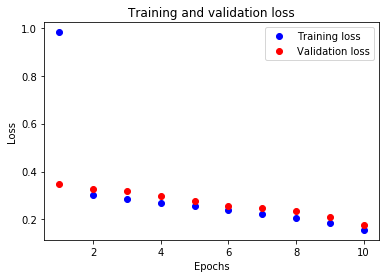

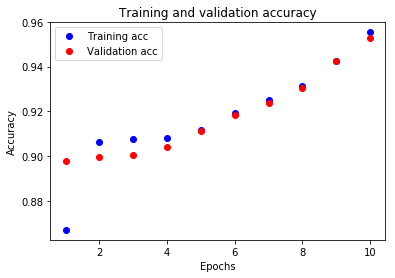

In [208]:
vis_loss(lstm_64.history)
vis_acc(lstm_64.history)

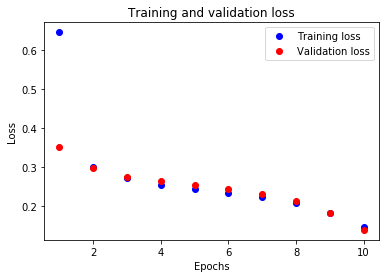

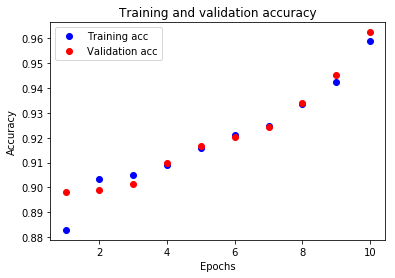

In [209]:
vis_loss(lstm_256.history)
vis_acc(lstm_256.history)

Переобучения не произошло

In [210]:
evals_64 = lstm_64.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [212]:
evals_256 = lstm_256.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [213]:
print('''
\tLoss\tAcc
64:\t{}\t{}
128:\t{}\t{}
256:\t{}\t{}'''.format(
    round(evals_64[0], 5), round(evals_64[1], 5),
    round(easy_lstm_evals[0], 5), round(easy_lstm_evals[1], 5),
    round(evals_256[0], 5), round(evals_256[1], 5)))


	Loss	Acc
64:	0.15499	0.9576
128:	0.13294	0.96778
256:	0.13268	0.96457


In [215]:
pred_64 = lstm_64.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
seqs_64, tags_64 = decode_sequences(pred_64)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(tags_64[i])
    print()

['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
['adv', 'verb', 'adv', 'adv', 'verb', 'verb']

['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
['adv', 'adv', 'verb', 'verb', 'cconj', 'cconj', 'noun', 'noun']

['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'cconj', 'adv', 'verb', 'noun', 'adj']
['verb', 'adv', 'verb', 'verb', 'adp', 'noun', 'noun', 'noun', 'cconj', 'noun', 'verb', 'verb', 'adp', 'noun', 'noun', 'verb', 'verb', 'verb', 'verb', 'verb', 'noun', 'noun']



Результаты как-то не очент радуют. Интересно, что модели умудляются предсказывать последовательности короче, т.е. предсказывают лишние паддинги -- кажется, их просто слишком много было.

In [98]:
# это старая модель, с которой сравниваем
easy_lstm_pred = easy_lstm.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
print(easy_lstm_pred.shape)
easy_lstm_seqs, easy_lstm_tags = decode_sequences(easy_lstm_pred)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(easy_lstm_tags[i])
    print()

(1088, 92, 15)
['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
['adv', 'verb', 'adv', 'adv', 'verb', 'verb']

['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
['verb', 'adv', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron']

['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'cconj', 'adv', 'verb', 'noun', 'adj']
['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'pron', 'verb', 'verb', 'noun', 'noun']



In [216]:
pred_256 = lstm_256.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
seqs_256, tags_256 = decode_sequences(pred_256)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(tags_256[i])
    print()

['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
['adv', 'verb', 'verb', 'verb', 'verb', 'verb']

['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
['verb', 'adv', 'verb', 'verb', 'verb', 'pron', 'cconj', 'adp', 'noun', 'verb', 'verb', 'noun', 'noun', 'pron']

['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'cconj', 'adv', 'verb', 'noun', 'adj']
['verb', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'verb', 'verb', 'verb', 'verb', 'verb', 'noun', 'noun']



In [219]:
bleu_64_1, bleu_64_2, bleu_64_3, bleu_64_4 = bleu_eval(test_tags[:1088], tags_64)

In [217]:
bleu_256_1, bleu_256_2, bleu_256_3, bleu_256_4 = bleu_eval(test_tags[:1088], tags_256)

In [247]:
print('''
\tBLEU-1\tBLEU-2\tBLEU-3\tBLEU-4
64:\t{}\t{}\t{}\t{}
128\t{}\t{}\t{}\t{}
256:\t{}\t{}\t{}\t{}
'''.format(round(bleu_64_1, 3), round(bleu_64_2, 3), round(bleu_64_3, 3), round(bleu_64_4, 3),
           round(lstm_bleu_1, 3), round(lstm_bleu_2, 3), round(lstm_bleu_2, 3), round(lstm_bleu_4, 3),
           round(bleu_256_1, 3), round(bleu_256_2, 3), round(bleu_256_2, 3), round(bleu_256_4, 3)))


	BLEU-1	BLEU-2	BLEU-3	BLEU-4
64:	0.64	0.465	0.349	0.223
128	0.721	0.58	0.58	0.333
256:	0.689	0.532	0.532	0.289



Мда. Кажется, размерность нам не поможет: 64 нейрона оказалось слишком мало, а 256 -- слишком сложно.

# Эксперименты с эмбеддингами

Теперь посмотрим, как  повлияет на точность изменение размерности эмбеддинга.

### 50

In [221]:
lstm_50 = Sequential()
lstm_50.add(Embedding(n_words, 50, input_length=max_len))
lstm_50.add(LSTM(n_hidden, return_sequences=True, unroll=True))
lstm_50.add(Dense(n_tags, activation="softmax"))

lstm_50.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_50.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 92, 50)            379750    
_________________________________________________________________
lstm_8 (LSTM)                (None, 92, 128)           91648     
_________________________________________________________________
dense_11 (Dense)             (None, 92, 15)            1935      
Total params: 473,333
Trainable params: 473,333
Non-trainable params: 0
_________________________________________________________________


In [222]:
checkpoint = ModelCheckpoint('cu\\easy-lstm\\cu-50_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_50_history = lstm_50.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(lstm_50_history.history, open('cu\\easy-lstm\\cu-50_model-history.json','w', encoding='utf-8'))

Epoch 1/10
51/51 [==============================] - 267s 5s/step - loss: 0.7933 - acc: 0.8848 - val_loss: 0.3670 - val_acc: 0.8977

Epoch 00001: saving model to cu\easy-lstm\cu-50_model-1.h5
Epoch 2/10
51/51 [==============================] - 175s 3s/step - loss: 0.3228 - acc: 0.9033 - val_loss: 0.3389 - val_acc: 0.8992

Epoch 00002: saving model to cu\easy-lstm\cu-50_model-2.h5
Epoch 3/10
51/51 [==============================] - 172s 3s/step - loss: 0.2887 - acc: 0.9044 - val_loss: 0.3036 - val_acc: 0.8998

Epoch 00003: saving model to cu\easy-lstm\cu-50_model-3.h5
Epoch 4/10
51/51 [==============================] - 174s 3s/step - loss: 0.2691 - acc: 0.9053 - val_loss: 0.2920 - val_acc: 0.9022

Epoch 00004: saving model to cu\easy-lstm\cu-50_model-4.h5
Epoch 5/10
51/51 [==============================] - 169s 3s/step - loss: 0.2562 - acc: 0.9102 - val_loss: 0.2959 - val_acc: 0.9078

Epoch 00005: saving model to cu\easy-lstm\cu-50_model-5.h5
Epoch 6/10
51/51 [===========================

### 150

In [229]:
lstm_150 = Sequential()
lstm_150.add(Embedding(n_words, embed_size, input_length=max_len))
lstm_150.add(LSTM(256, return_sequences=True, unroll=True))
lstm_150.add(Dense(n_tags, activation="softmax"))

lstm_150.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_150.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 92, 100)           759500    
_________________________________________________________________
lstm_10 (LSTM)               (None, 92, 256)           365568    
_________________________________________________________________
dense_13 (Dense)             (None, 92, 15)            3855      
Total params: 1,128,923
Trainable params: 1,128,923
Non-trainable params: 0
_________________________________________________________________


In [230]:
checkpoint = ModelCheckpoint('cu\\easy-lstm\\cu-150_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_150_history = lstm_150.fit_generator(
    generator=gen_batch(train_sents, train_tags, batch_size), 
    steps_per_epoch=steps,
    validation_data=gen_batch(val_sents, val_tags, batch_size),
    validation_steps=val_steps,
    epochs=epochs, verbose=1, callbacks=[checkpoint])
dump(lstm_150_history.history, open('cu\\easy-lstm\\cu-150_model-history.json','w', encoding='utf-8'))

Epoch 1/10
51/51 [==============================] - 825s 16s/step - loss: 0.6201 - acc: 0.8843 - val_loss: 0.3454 - val_acc: 0.8985

Epoch 00001: saving model to cu\easy-lstm\cu-150_model-1.h5
Epoch 2/10
51/51 [==============================] - 620s 12s/step - loss: 0.2948 - acc: 0.9040 - val_loss: 0.3065 - val_acc: 0.8987

Epoch 00002: saving model to cu\easy-lstm\cu-150_model-2.h5
Epoch 3/10
51/51 [==============================] - 637s 12s/step - loss: 0.2665 - acc: 0.9048 - val_loss: 0.2755 - val_acc: 0.9014

Epoch 00003: saving model to cu\easy-lstm\cu-150_model-3.h5
Epoch 4/10
51/51 [==============================] - 645s 13s/step - loss: 0.2507 - acc: 0.9104 - val_loss: 0.2783 - val_acc: 0.9100

Epoch 00004: saving model to cu\easy-lstm\cu-150_model-4.h5
Epoch 5/10
51/51 [==============================] - 652s 13s/step - loss: 0.2384 - acc: 0.9173 - val_loss: 0.2699 - val_acc: 0.9164

Epoch 00005: saving model to cu\easy-lstm\cu-150_model-5.h5
Epoch 6/10
51/51 [=================

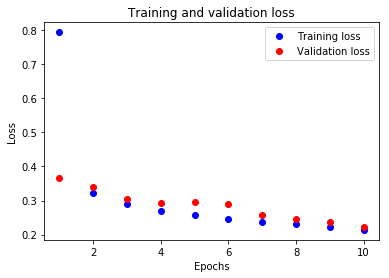

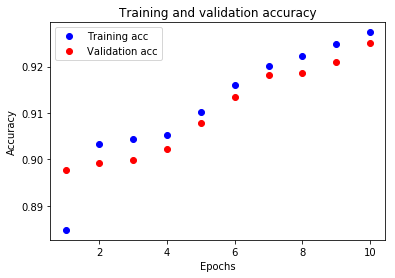

In [223]:
vis_loss(lstm_50.history)
vis_acc(lstm_50.history)

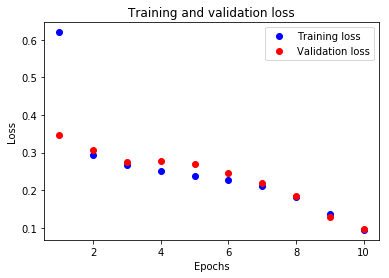

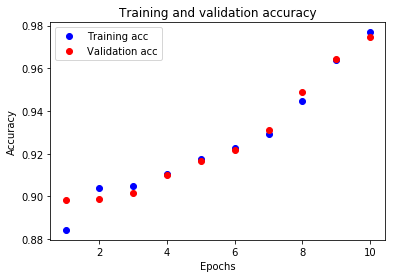

In [232]:
vis_loss(lstm_150.history)
vis_acc(lstm_150.history)

Переобучения нет, а красивые графики -- есть)

In [224]:
evals_50 = lstm_50.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [233]:
evals_150 = lstm_150.evaluate_generator(gen_batch(test_sents, test_tags, batch_size), steps=test_steps, max_queue_size=max_len)

In [234]:
print('''
\tLoss\tAcc
50:\t{}\t{}
100:\t{}\t{}
150:\t{}\t{}'''.format(
    round(evals_50[0], 5), round(evals_50[1], 5),
    round(easy_lstm_evals[0], 5), round(easy_lstm_evals[1], 5),
    round(evals_150[0], 5), round(evals_150[1], 5)))


	Loss	Acc
50:	0.21183	0.9293
100:	0.13294	0.96778
150:	0.09277	0.97617


In [226]:
pred_50 = lstm_50.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
seqs_50, tags_50 = decode_sequences(pred_50)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(tags_64[i])
    print()

['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
['adv', 'verb', 'adv', 'adv', 'verb', 'verb']

['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
['adv', 'adv', 'verb', 'verb', 'cconj', 'cconj', 'noun', 'noun']

['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'cconj', 'adv', 'verb', 'noun', 'adj']
['verb', 'adv', 'verb', 'verb', 'adp', 'noun', 'noun', 'noun', 'cconj', 'noun', 'verb', 'verb', 'adp', 'noun', 'noun', 'verb', 'verb', 'verb', 'verb', 'verb', 'noun', 'noun']



In [98]:
# это старое
easy_lstm_pred = easy_lstm.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
print(easy_lstm_pred.shape)
easy_lstm_seqs, easy_lstm_tags = decode_sequences(easy_lstm_pred)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(easy_lstm_tags[i])
    print()

(1088, 92, 15)
['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
['adv', 'verb', 'adv', 'adv', 'verb', 'verb']

['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
['verb', 'adv', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron']

['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'cconj', 'adv', 'verb', 'noun', 'adj']
['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'pron', 'verb', 'verb', 'noun', 'noun']



In [243]:
pred_150 = lstm_150.predict_generator(gen_batch(test_sents_clean, test_tags, batch_size), steps=int(len(test_sents_clean)/batch_size))
seqs_150, tags_150 = decode_sequences(pred_150)
for i in range(3):
    print(test_tags[i])
    #print(dec_seqs[i])
    print(tags_150[i])
    print()

['adv', 'verb', 'sconj', 'adv', 'verb', 'verb']
['adv', 'verb', 'adv', 'adv', 'verb', 'verb']

['pron', 'adv', 'noun', 'verb', 'verb', 'pron', 'cconj', 'adp', 'pron', 'noun', 'verb', 'verb', 'aux', 'pron']
['adv', 'adv', 'verb', 'verb', 'verb', 'pron', 'cconj', 'noun', 'pron', 'verb', 'noun', 'noun', 'aux', 'pron']

['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'cconj', 'adv', 'verb', 'noun', 'adj']
['pron', 'adv', 'verb', 'noun', 'adp', 'noun', 'noun', 'adj', 'cconj', 'noun', 'pron', 'verb', 'adp', 'noun', 'adj', 'adv', 'verb', 'adv', 'adv', 'verb', 'noun', 'verb']



In [240]:
bleu_50_1, bleu_50_2, bleu_50_3, bleu_50_4 = bleu_eval(test_tags[:1088], tags_50)

In [244]:
bleu_150_1, bleu_150_2, bleu_150_3, bleu_150_4 = bleu_eval(test_tags[:1088], tags_150)

In [245]:
print('''
\tBLEU-1\tBLEU-2\tBLEU-3\tBLEU-4
64:\t{}\t{}\t{}\t{} 
128\t{}\t{}\t{}\t{}
150:\t{}\t{}\t{}\t{}
'''.format(round(bleu_50_1, 3), round(bleu_50_2, 3), round(bleu_50_3, 3), round(bleu_50_4, 3),
           round(lstm_bleu_1, 3), round(lstm_bleu_2, 3), round(lstm_bleu_2, 3), round(lstm_bleu_4, 3),
           round(bleu_150_1, 3), round(bleu_150_2, 3), round(bleu_150_2, 3), round(bleu_150_4, 3)))


	BLEU-1	BLEU-2	BLEU-3	BLEU-4
64:	0.36	0.161	0.112	0.067
128	0.721	0.58	0.58	0.333
150:	0.782	0.67	0.67	0.458



О, а вот эмбеддинги творят магию) Чем больше информации удаётся сохранить о словах, тем лучше работает моделька. Только я забыла поменять числа и слишком поздно это заметила :с Тут 50, 100 и 150

Мы хотели посмотреть, получится и lstm "догнать" собратьев. Сравним, что в итоге вышло:

In [246]:
print('''
\t\tBLEU-1\tBLEU-2\tBLEU-3\tBLEU-4
SimpleRNN:\t{}\t{}\t{}\t{}
LSTM:\t\t{}\t{}\t{}\t{}
LSTM-150:\t{}\t{}\t{}\t{}
BiLSTM:\t\t{}\t{}\t{}\t{}
GRU:\t\t{}\t{}\t{}\t{}
'''.format(round(simple_bleu_1, 3), round(simple_bleu_2, 3), round(simple_bleu_3, 3), round(simple_bleu_4, 3),
           round(lstm_bleu_1, 3), round(lstm_bleu_2, 3), round(lstm_bleu_2, 3), round(lstm_bleu_4, 3),
           round(bleu_150_1, 3), round(bleu_150_2, 3), round(bleu_150_2, 3), round(bleu_150_4, 3),
           round(bilstm_bleu_1, 3), round(bilstm_bleu_2, 3), round(bilstm_bleu_2, 3), round(bilstm_bleu_4, 3),
           round(gru_bleu_1, 3), round(gru_bleu_2, 3), round(gru_bleu_3, 3), round(gru_bleu_4, 3)))


		BLEU-1	BLEU-2	BLEU-3	BLEU-4
SimpleRNN:	0.862	0.791	0.729	0.625
LSTM:		0.721	0.58	0.58	0.333
LSTM-150:	0.782	0.67	0.67	0.458
BiLSTM:		0.87	0.798	0.798	0.635
GRU:		0.884	0.821	0.766	0.669



Собратьев мы не догнали, но качество предсказаний всё равно повысили, ура! 

Итак, важный вывод -- вовсе не всегда что-то сложное рабоает лучше, чем простое. Слишком сложные модели могут строить слишком сложные гипотезы -- может быть, проблема нашей LSTM была как раз в том, что она уловила какие-то несуществующие долгосрочные зависимости. Ну и, конечно же, важно, сколько информации о слове мы сможем сохранить в эмбеддингах. 